In [47]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score


In [7]:
df=pd.read_csv("/content/diabetic_data.csv")

In [8]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [11]:
df.isnull().sum()

,0
encounter_id,0
patient_nbr,0
race,0
gender,0
age,0
weight,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0


In [12]:
df.drop(['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'], axis=1, inplace=True)

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

In [15]:
df.replace({'readmitted': {'NO': 0, '<30': 1, '>30': 0}}, inplace=True)

/tmp/ipython-input-2127228191.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'readmitted': {'NO': 0, '<30': 1, '>30': 0}}, inplace=True)


<Axes: xlabel='readmitted', ylabel='count'>

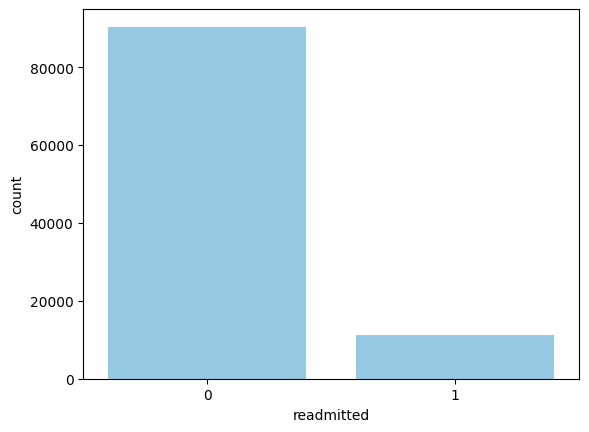

In [16]:
sns.countplot(x='readmitted', data=df, color="#89CFF0")


<Axes: xlabel='gender'>

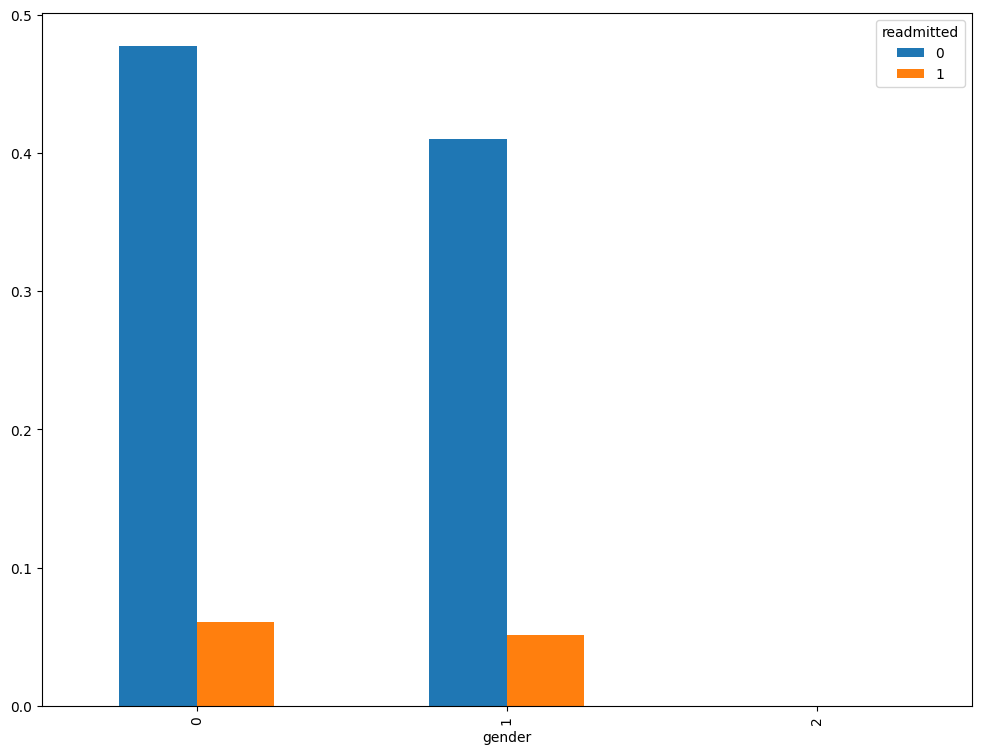

In [45]:
d = df[['gender', 'readmitted']]

cont_table = pd.crosstab(index=d['gender'], columns=df['readmitted'], normalize=True)

cont_table.plot.bar(figsize=(12, 9))

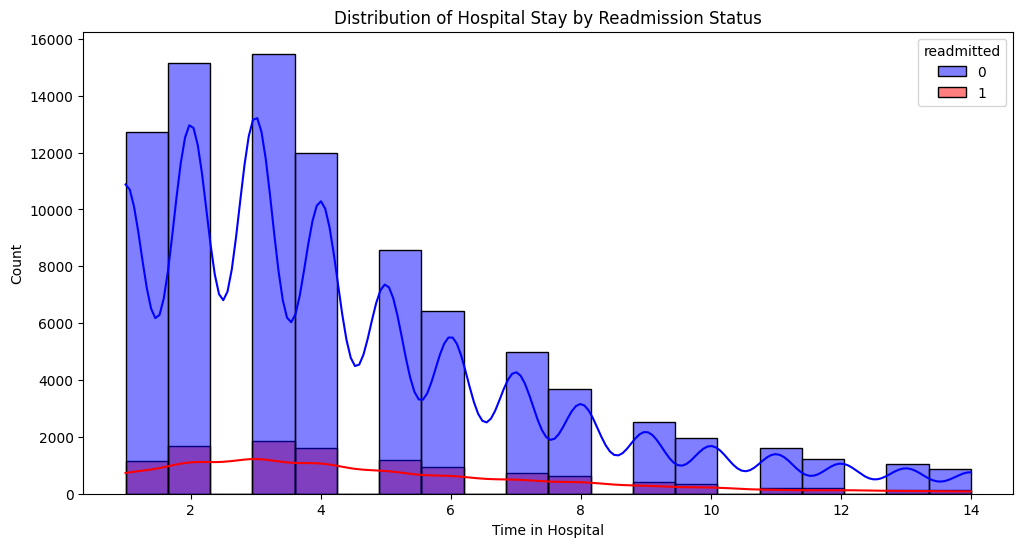

In [38]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="time_in_hospital", hue="readmitted",
             bins=20, kde=True, palette={0:"blue", 1:"red"}, alpha=0.5)
plt.xlabel("Time in Hospital")
plt.ylabel("Count")
plt.title("Distribution of Hospital Stay by Readmission Status")
plt.show()


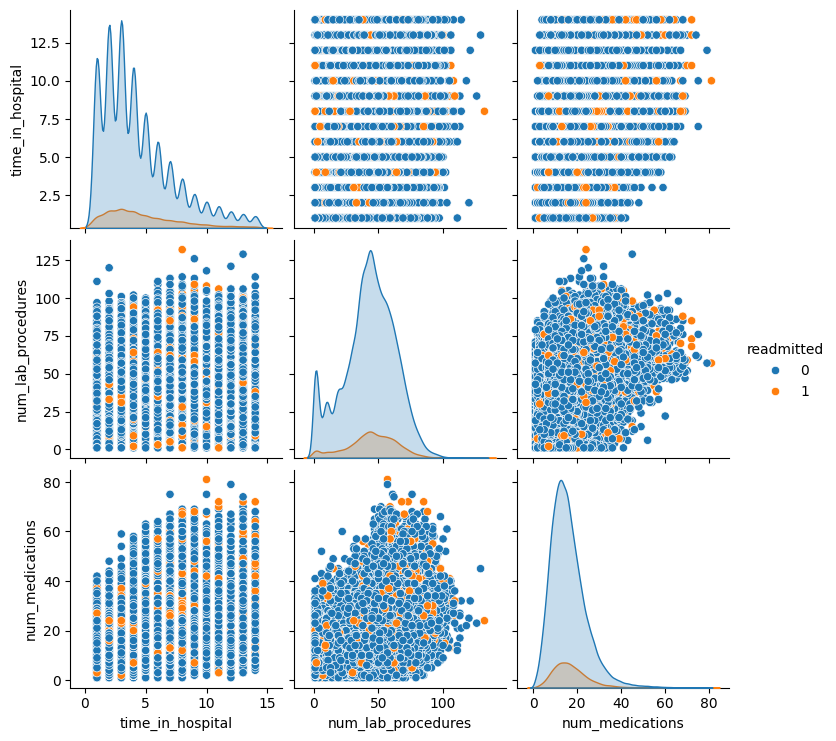

In [40]:
sns.pairplot(df[['time_in_hospital','num_lab_procedures','num_medications','readmitted']], hue="readmitted")


In [17]:

df = df[df['race'] != '?']



In [18]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [22]:
df = df.apply(lambda x: LabelEncoder().fit_transform(x.astype(str))
              if x.dtype == 'object' else x)

In [24]:
X = df.drop('readmitted', axis=1)
y = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [29]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test)

In [30]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.8572290064827378
[[16878   787]
 [ 2054   180]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     17665
           1       0.19      0.08      0.11      2234

    accuracy                           0.86     19899
   macro avg       0.54      0.52      0.52     19899
weighted avg       0.81      0.86      0.83     19899



In [31]:
from sklearn.metrics import confusion_matrix

y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))


[[16878   787]
 [ 2054   180]]


In [33]:
cm = np.array([[16878, 787],
               [2054, 180]])

TN, FP, FN, TP = cm.ravel()
total = cm.sum()

print("False Positives:", FP, "(", round(FP/total*100, 2), "% )")
print("False Negatives:", FN, "(", round(FN/total*100, 2), "% )")


False Positives: 787 ( 3.95 % )
False Negatives: 2054 ( 10.32 % )


                     Feature  Importance
42                    change    0.068641
13                    diag_1    0.061811
14                    diag_2    0.059467
36                   insulin    0.058866
15                    diag_3    0.058737
7         num_lab_procedures    0.057539
9            num_medications    0.052101
5        admission_source_id    0.049240
4   discharge_disposition_id    0.049115
2                        age    0.045437


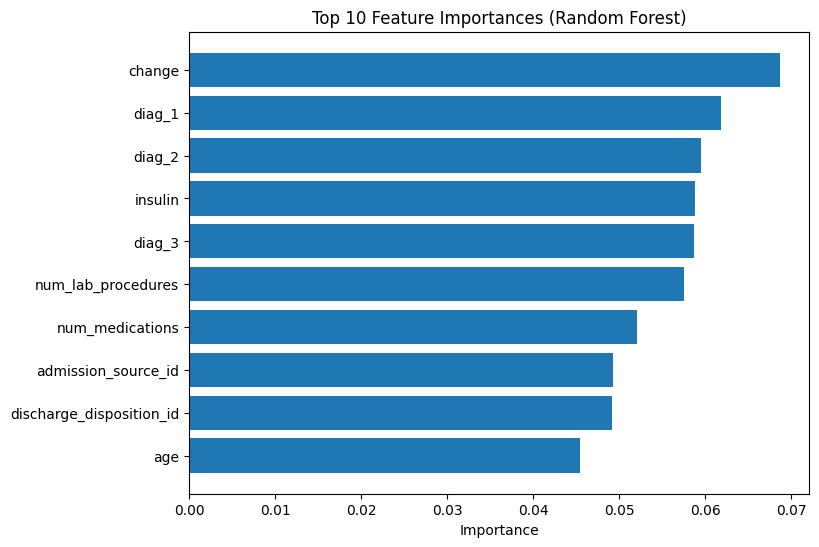

In [35]:
importances = rf.feature_importances_
features = X_train.columns

feat_imp = pd.DataFrame({"Feature": features, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

top_n = 10
top_features = feat_imp.head(top_n)

print(top_features)

plt.figure(figsize=(8,6))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.show()

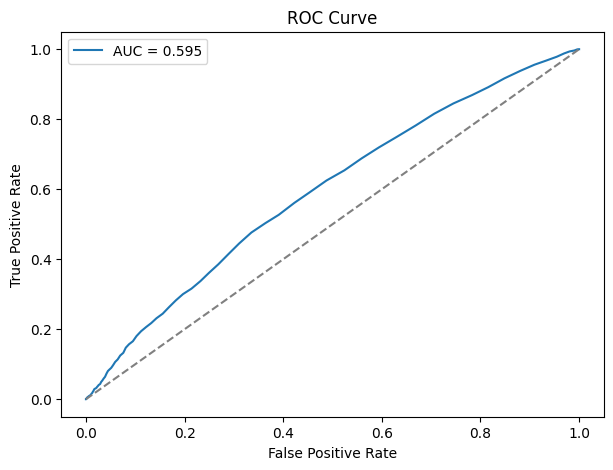

In [46]:
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [50]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    "RandomForest": rf,
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    preds = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, preds))



RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     17665
           1       0.19      0.08      0.11      2234

    accuracy                           0.86     19899
   macro avg       0.54      0.52      0.52     19899
weighted avg       0.81      0.86      0.83     19899



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80     17665
           1       0.13      0.35      0.19      2234

    accuracy                           0.67     19899
   macro avg       0.51      0.53      0.49     19899
weighted avg       0.81      0.67      0.73     19899



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:57:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     17665
           1       0.20      0.13      0.16      2234

    accuracy                           0.85     19899
   macro avg       0.55      0.53      0.54     19899
weighted avg       0.82      0.85      0.83     19899

[LightGBM] [Info] Number of positive: 70659, number of negative: 70659
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1190
[LightGBM] [Info] Number of data points in the train set: 141318, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     1